# Coursework 1 - Supervised learning

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
    - [(2.1.4)](#task-214) <a name="index-task-214"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>



---



<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load dataset
data = pd.read_csv('nanoelectrodes_capacitance_samples.csv')

X_train = data.drop("Capacitance ($\mu F / cm^2$)", axis = 'columns')
y_train = data["Capacitance ($\mu F / cm^2$)"]

test_data = pd.read_csv('nanoelectrodes_capacitance_test.csv')
X_test = test_data.drop("Capacitance ($\mu F / cm^2$)", axis = 'columns')
y_test = test_data["Capacitance ($\mu F / cm^2$)"]

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

In [3]:
def loss(y, y_pred):
    return ((y - y_pred) ** 2).sum()

In [75]:
def mse(y_true, y_pred):
    """Compute MSE-loss

    Parameters:
        y_true: ground-truth array, with shape (K, )
        y_pred: predictions array, with shape (K, )

    Returns:
        loss (float): MSE-loss
    """
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)


    return np.mean((y_true - y_pred)**2, keepdims=True)[0]

In [5]:
def rsq(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [6]:
def split_samples(X, y, column, value):
    """
    Return the split of data whose column-th feature:
        less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples
    Returns:
        tuple(np.array, np.array): tuple of the left split data (X_l, y_l).
        tuple(np.array, np.array): tuple of the right split data (X_l, y_l)
    """

    left_mask = (X[:, column] < value)

    # Using the binary masks `left_mask`, we split X and y.
    X_l, y_l = X[left_mask], y[left_mask] 
    X_r, y_r = X[~left_mask], y[~left_mask] 

    return (X_l, y_l), (X_r, y_r)

In [7]:
def loss_split_value(X, y, column):
    """
    Calculate the mse based on `column` with the split that minimizes the loss.
    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
    Returns:
        (float, float): the resulted mse and the corresponding value used in splitting.
    """

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    loss_val, threshold = np.inf, None

    # split the values of i-th feature and calculate the cost
    for value in unique_vals:
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, column, value) 

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        new_loss = loss(y_l, y_l.mean()) + loss(y_r, y_r.mean()) 
        if new_loss < loss_val:
              loss_val, threshold = new_loss, value

    return loss_val, threshold

In [8]:
def loss_split(X, y):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
    Returns:
        (int, float): the best feature index and value used in splitting.
        If the feature index is None, then no valid split for the current Node.
    """

    # Initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_loss = np.inf
    split_column = None
    split_val = np.nan
    m, n = X.shape

    for col in range(n):
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, col])) < 2:
            continue
        loss, current_split_val = loss_split_value(X, y, col)  

        # To scan for the best split corresponding the minimum mse_index
        if loss < min_loss: 
            # Keep track with:

            # 1. the current minimum mse value,
            min_loss = loss

            # 2. corresponding column,
            split_column = col

            # 3. corresponding split threshold.
            split_val = current_split_val 

    return split_column, split_val

In [9]:
loss_split(X_train.to_numpy(), y_train.to_numpy())

(5, 2.5)

In [10]:
def build_tree(X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'mean_value': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          5. 'left': The left sub-tree with the same structure.
          6. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) no feature, (ii) depth exceed, or (iii) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': np.mean(y)}

    split_index, split_val = loss_split(X, y)

    # If no valid split at this node, use mean.
    if split_index is None:
        return {'mean_value': np.mean(y)}

    # Split samples (X, y) given column and split-value.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val) 
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'mean_value': None,
        'left': build_tree(X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

In [11]:
def train(X, y):
    """
    Build the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
    """
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    return build_tree(X, y, feature_names, depth=1)

In [12]:
tree = train(X_train, y_train)

In [13]:
def find(tree, x):
    """
    Find the branch of a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    
    if tree['mean_value'] is not None:
        return tree['mean_value']

    if x[tree['feature_index']] < tree['value']: 
        # go to left branch
        return find(tree['left'], x)  
    else:
        # go to right branch
        return find(tree['right'], x)  

In [14]:
def predict(tree, X):
    """
    Predict regression results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return find(tree, X)
    else:
        return np.array([find(tree, x) for x in X])

In [15]:
def tree_results(tree, X, y):
    """
    Return the R^2 and MSE score of the tree on the data.
    Args:
        tree: (dict) the decision tree.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
        y: (pd.Series) vector of testing labels, of shape (N,).
    Returns:
        (float): R^2 score of the tree on the data.
        (float): MSE score of the tree on the data.
    """
    y_pred = predict(tree, X.to_numpy())
    return mse(y, y_pred)[0], rsq(y, y_pred)

In [16]:
tree_train_results = tree_results(tree, X_train, y_train.to_numpy())
tree_test_results = tree_results(tree, X_test, y_test.to_numpy())
print(tree_train_results)
print(tree_test_results)

(1654.4051506951573, 0.7503640060081044)
(3369.5671069811706, 0.4896216113769649)


<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

In [17]:
def loss_split_rf(n_features, X, y):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
    Returns:
        (float, int, float): the minimized loss value.
    """
    # The added sampling step.
    columns = np.random.choice(list(range(12)), n_features, replace=False)


    min_loss_val, split_column, split_val = np.inf, 0, 0

    # Only scan through the sampled columns in `columns_dict`.
    for column in columns:
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        loss_val, val = loss_split_value(X, y, column)
        if loss_val < min_loss_val:
            min_loss_val, split_column, split_val = loss_val, column, val

    return min_loss_val, split_column, split_val

In [18]:
def build_tree_rf(n_features, X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': np.mean(y)}

    else:
        loss, split_column, split_val = loss_split_rf(n_features, X, y)

        # If loss is infinity, it means that samples are not seperable by the sampled features.
        if loss == np.inf:
            return {'mean_value': np.mean(y)}
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_column, split_val)
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'mean_value': None,
            'left': build_tree_rf(n_features, X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [19]:
def train_rf(B, n_features, X, y):
    """
    Build the decision tree according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
    """
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True) 

        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, feature_names, depth=1)
        trees.append(tree)

    return trees

In [20]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    if len(X.shape) == 1:
        # if we have one sample
        return np.mean([find(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([np.mean([find(tree, x) for tree in rf]) for x in X])

In [21]:
def rf_results(rf, X, y):
    """
    Return the R^2 and MSE score of the random forest on the data.
    Args:
        rf: (list) the random forest.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
        y: (pd.Series) vector of testing labels, of shape (N,).
    Returns:
        (float): R^2 score of the rf on the data.
        (float): MSE score of the rf on the data.
    """
    y_pred = predict_rf(rf, X)
    return mse(y, y_pred)[0], rsq(y, y_pred)

In [22]:
n_features = int(X_train.shape[1]/3)

In [23]:
B = 30 # this will change later after optimisation
# fit the random forest with training data
rf = train_rf(B, n_features, X_train, y_train)

In [24]:
print(rf_results(rf, X_train.to_numpy(), y_train.to_numpy()))
print(rf_results(rf, X_test.to_numpy(), y_test.to_numpy()))

(1305.6844826930958, 0.8029830579650171)
(3235.2520467401882, 0.5099659172884191)


In [25]:
def n_fold_cross_validation(X, y, B, n_features, n_folds=5):

  N = X.shape[0]
  fold_size = N // n_folds
  scores = []

  for i in range(n_folds):
    test_indices = list(range(i * fold_size, (i + 1) * fold_size))
    train_indices = list(set(range(N)) - set(test_indices))
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
  
  rf = train_rf(B, n_features, X_train, y_train)

  scores.append(mse(predict_rf(rf, X_test.to_numpy()), y_test.to_numpy()))

  # Return the average score
  return np.mean(scores) 

In [26]:
from tqdm.notebook import tqdm

In [27]:
def choose_best_B(X_train, y_train, n_folds, B_max):
  wide_B_range = [1] + list(np.arange(10, B_max, 10))
  B_scores_wide = np.zeros((len(wide_B_range)))
  
  for i, B in enumerate(wide_B_range):
    B_scores_wide[i] = n_fold_cross_validation(X_train, y_train, B, 12, n_folds)
    print(f'Loss@B={B}: {B_scores_wide[i]:.3f}')

  best_B_index_wide = np.argmin(B_scores_wide)

  B_range = np.arange(wide_B_range[best_B_index_wide] - 10, wide_B_range[best_B_index_wide] + 10)
  B_scores = np.zeros((len(B_range)))

  for i, B in enumerate(B_range):
    B_scores[i] = n_fold_cross_validation(X_train, y_train, B, 12, n_folds)
    print(f'Loss@B={B}: {B_scores[i]:.3f}')
  
  best_B_index = np.argmin(B_scores)

  return B_range[best_B_index], B_scores, B_scores_wide

In [418]:
b_hat, scores_reduced, scores_range = choose_best_B(X_train, y_train, 5, 101)

Loss@B=1: 7299.957
Loss@B=10: 4076.023
Loss@B=20: 3907.041
Loss@B=30: 3970.694
Loss@B=40: 3967.036
Loss@B=50: 3934.762
Loss@B=60: 3764.034
Loss@B=70: 3676.433
Loss@B=80: 4037.572
Loss@B=90: 3749.340
Loss@B=100: 3859.893
Loss@B=60: 3848.794
Loss@B=61: 3782.780
Loss@B=62: 4063.747
Loss@B=63: 3732.088
Loss@B=64: 3947.512
Loss@B=65: 4071.254
Loss@B=66: 3908.277
Loss@B=67: 4039.653


KeyboardInterrupt: 

In [31]:
plt.plot(range(len(scores_range)), scores_range)

NameError: name 'scores_range' is not defined

In [28]:
b_hat = 25

In [29]:
rf_hat = train_rf(b_hat, n_features, X_train, y_train)
rf_train_results = rf_results(rf_hat, X_train.to_numpy(), y_train.to_numpy())
rf_test_results = rf_results(rf_hat, X_test.to_numpy(), y_test.to_numpy())
print(rf_train_results)
print(rf_test_results)

(1251.4358974775657, 0.8111687188276193)
(3490.727457081233, 0.4712698106008488)


In [30]:
def importance(rf, X):
    """
    Calculate the importance of each feature in the random forest.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): the importance of each feature, of shape (p,).
    """
    return np.array([np.mean([tree['feature_index'] for tree in rf]) for x in X])

In [31]:
def loss_split_bag(X, y):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
    Returns:
        (float, int, float): the minimized loss value.
    """
    min_loss_val, split_column, split_val = np.inf, 0, 0

    for column in range(12):
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        loss_val, val = loss_split_value(X, y, column)
        if loss_val < min_loss_val:
            min_loss_val, split_column, split_val = loss_val, column, val

    return min_loss_val, split_column, split_val

In [32]:
def build_tree_bag(X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': np.mean(y)}

    else:
        loss, split_column, split_val = loss_split_bag(X, y)

        # If loss is infinity, it means that samples are not seperable by the sampled features.
        if loss == np.inf:
            return {'mean_value': np.mean(y)}
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_column, split_val)
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'mean_value': None,
            'left': build_tree_bag(X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_bag(X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [33]:
def train_bag(B, X, y):
    """
    Build the decision tree according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
    """
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True) 

        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_bag(X_sample, y_sample, feature_names, depth=1)
        trees.append(tree)

    return trees

In [34]:
def predict_bag(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    if len(X.shape) == 1:
        # if we have one sample
        return np.mean([find(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([np.mean([find(tree, x) for tree in rf]) for x in X])

In [35]:
def bag_results(rf, X, y):
    """
    Return the R^2 and MSE score of the random forest on the data.
    Args:
        rf: (list) the random forest.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
        y: (pd.Series) vector of testing labels, of shape (N,).
    Returns:
        (float): R^2 score of the rf on the data.
        (float): MSE score of the rf on the data.
    """
    y_pred = predict_bag(rf, X)
    return mse(y, y_pred)[0], rsq(y, y_pred)

In [36]:
rf_bag = train_bag(b_hat, X_train, y_train)

In [37]:
bag_train_results = bag_results(rf_bag, X_train.to_numpy(), y_train.to_numpy())
bag_test_results = bag_results(rf_bag, X_test.to_numpy(), y_test.to_numpy())
print(bag_train_results)
print(bag_test_results)

(1044.1802187203273, 0.8424418790660824)
(2357.8616015111, 0.6428616595045339)


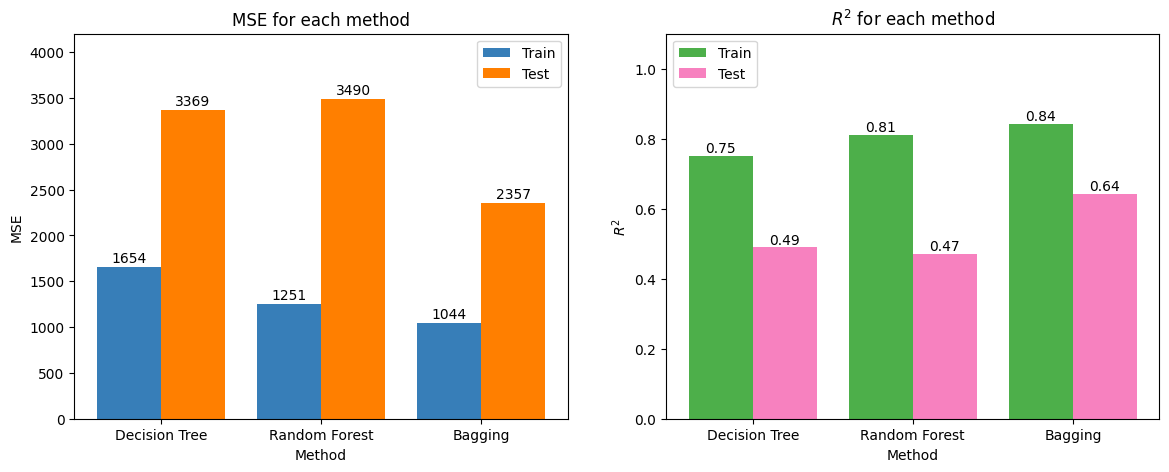

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

labels = ('Decision Tree', 'Random Forest', 'Bagging')

MSE_vals_train = [tree_train_results[0], rf_train_results[0], bag_train_results[0]]
MSE_vals_test = [tree_test_results[0], rf_test_results[0], bag_test_results[0]]
rsq_vals_train = [tree_train_results[1], rf_train_results[1], bag_train_results[1]]
rsq_vals_test = [tree_test_results[1], rf_test_results[1], bag_test_results[1]]

X_axis = np.arange(len(labels))

ax[0].bar(X_axis - 0.2, MSE_vals_train, 0.4, color = '#377eb8', label = 'Train')
ax[0].bar(X_axis + 0.2, MSE_vals_test, 0.4, color = '#ff7f00', label = 'Test')
ax[0].set_ylabel('MSE')
ax[0].set_ylim(0, 4200)
ax[0].set_title('MSE for each method')
ax[0].legend(loc = 'upper right')
ax[0].set_xticks(X_axis, labels)
ax[0].set_xlabel('Method')

for i, v in enumerate(MSE_vals_train):
    ax[0].text(i - 0.2, v + 50, str(int(v)), ha = 'center')

for i, v in enumerate(MSE_vals_test):
    ax[0].text(i + 0.2, v + 50, str(int(v)), ha = 'center')

ax[1].bar(X_axis - 0.2, rsq_vals_train, 0.4, color = '#4daf4a', label = 'Train')
ax[1].bar(X_axis + 0.2, rsq_vals_test, 0.4, color = '#f781bf', label = 'Test')
ax[1].set_ylabel(r'$R^2$')
ax[1].set_ylim(0, 1.1)
ax[1].set_title(r'$R^2$ for each method')
ax[1].legend(loc = 'upper left')
ax[1].set_xticks(X_axis, labels)
ax[1].set_xlabel('Method')

for i, v in enumerate(rsq_vals_train):
    ax[1].text(i - 0.2, v + 0.01, str(round(v, 2)), ha = 'center')

for i, v in enumerate(rsq_vals_test):
    ax[1].text(i + 0.2, v + 0.01, str(round(v, 2)), ha = 'center')

<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

In [39]:
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True) 
    sigma = np.std(X_train_, axis=0, keepdims=True) 
    X_std = (X - mu) / sigma 
    return X_std

In [40]:
X_train_std = standardise(X_train.to_numpy())
X_test_std = standardise(X_test.to_numpy(), X_train_=X_train.to_numpy())

In [41]:
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in if the input features dimension.
        W (np.ndarray): h_out x h_in array for kernel matrix parametersm, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X])
    return a

In [42]:
def activation(a):
    """activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.arctan(a) * np.log(np.abs(a) + 1)
    return h

## EDIT THIS FUNCTION
def grad_activation(a):
    """Gradient of activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = np.log(np.abs(a) + 1) / (1 + a ** 2) + (np.arctan(a) * np.sign(a)) / (np.abs(a) + 1)
    return grad

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{50 \times 12}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{50}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{50\times 50}$, $k=1, 2$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{50}$, $k=1, 2$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{1 \times 50}$
* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{1}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation](http://proceedings.mlr.press/v9/glorot10a.html). The bias parameters will be initialised to zeros.

In [43]:
# A lookup table for activation functions by their names.
activation_table = {
    "activation": activation,
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "activation": grad_activation,
    "identity": lambda x: np.ones_like(x)
}


class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=54):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim),
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"]) 
            activation = activation_table[self.layers[k]["activation"]] 
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)}) 

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"]) 
        # predicted target is output of last layer
        return y_hat, forward_pass

In [44]:
mlp = MLP(seed=91)
mlp.add_layer(12, 50)
mlp.add_layer(50, 50, "activation")
mlp.add_layer(50, 50, "activation")
mlp.add_layer(50, 1, "activation")
print("Number of layers:", mlp.n_layers())
print("Number of trainable parameters:", mlp.n_parameters())

Number of layers: 4
Number of trainable parameters: 5801


In [45]:
y_hat_train, forward_pass = mlp.predict(X_train_std)

In [46]:
def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss

    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).

    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size

In [47]:
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$. The

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."


        gradients.append({"W" : delta.T @ h, 
                          "b" : delta.sum(axis=0)}) 

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)]) 


    # Return now ordered list matching the layers.
    return list(reversed(gradients))

In [48]:
def sgd_step(X, y, mlp, learning_rate = 5e-5, momentum=None, v_t=None):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, D).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X) 

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat) 

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)  

    # mlp.layers and gradients are symmetric, as shown in the figure.
    if momentum is not None and v_t is not None:
        updated_layers, updated_v = [], []
        for layer, grad, v in zip(mlp.layers, gradients, v_t):
            adj_W = momentum * v["W"] + learning_rate * grad["W"]
            W = layer["W"] - adj_W

            adj_b = momentum * v["b"] + learning_rate * grad["b"]
            b = layer["b"] - adj_b

            updated_layers.append({"W": W, "b": b,
                                   "activation": layer["activation"],
                                   "index": layer["index"]})

            updated_v.append({"W": adj_W, "b": adj_b})
        return updated_layers, updated_v
    
    elif momentum is not None or v_t is not None:
        raise ValueError("Need both momentum and v_t together.")
    
    else:
        updated_layers = []
        for layer, grad in zip(mlp.layers, gradients):
            W = layer["W"] - learning_rate * grad["W"] 
            b = layer["b"] - learning_rate * grad["b"] 
            updated_layers.append({"W": W, "b": b,
                                # keep the activation function.
                                "activation": layer["activation"],
                                # We use the index for asserts and debugging purposes only.
                                "index": layer["index"]})
    return updated_layers

In [49]:
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 5e-5,
        n_epochs=300, minibatchsize=8, seed=91, momentum=None):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (|D_train|, D).
        y_train (np.ndarray): The training data ground-truth, with shape (|D_train|, 1).
        X_test (np.ndarray): The testing data features, with shape (|D_test|, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (|D_test|, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))

    if momentum is not None:
        for i in epochs_bar:

            # shuffle data
            p = rng.permutation(len(y_train))
            X_train_shuffled = X_train[p]
            y_train_shuffled = y_train[p]

            v_t = [{"W": np.zeros_like(mlp.layers[i]["W"]), "b": np.zeros_like(mlp.layers[i]["b"])} for i in range(len(mlp.layers))]

            for j in range(n_iterations):
                # get batch
                X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
                y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

                # apply sgd step
                updated_layers, updated_v = sgd_step(X_batch, y_batch, mlp, learning_rate, momentum, v_t) 

                # update weights and biases of MLP
                mlp.layers = updated_layers 
                v_t = updated_v

            # compute loss at the end of each epoch
            y_hat_train, _ = mlp.predict(X_train)
            losses_train.append(mse(y_train, y_hat_train).squeeze())
            y_hat_test, _ = mlp.predict(X_test)
            losses_test.append(mse(y_test, y_hat_test).squeeze())
            epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                    f'test_loss: {losses_test[-1]:.2f}, '
                                    f'train_R^2: {rsq(y_train, y_hat_train):.2f} '
                                    f'test_R^2: {rsq(y_test, y_hat_test):.2f} ')
    else:
        for i in epochs_bar:

            # shuffle data
            p = rng.permutation(len(y_train))
            X_train_shuffled = X_train[p]
            y_train_shuffled = y_train[p]

            for j in range(n_iterations):
                # get batch
                X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
                y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

                # apply sgd step
                updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate) 

                # update weights and biases of MLP
                mlp.layers = updated_layers 

            # compute loss at the end of each epoch
            y_hat_train, _ = mlp.predict(X_train)
            losses_train.append(mse(y_train, y_hat_train).squeeze())
            y_hat_test, _ = mlp.predict(X_test)
            losses_test.append(mse(y_test, y_hat_test).squeeze())
            epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                    f'test_loss: {losses_test[-1]:.2f}, '
                                    f'train_R^2: {rsq(y_train, y_hat_train):.2f} '
                                    f'test_R^2: {rsq(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test


In [50]:
mlp = MLP(seed=1)
mlp.add_layer(12, 50)
mlp.add_layer(50, 50, "activation")
mlp.add_layer(50, 50, "activation")
mlp.add_layer(50, 1, "activation")
print("Number of layers:",mlp.n_layers())
print("Number of trainable parameters:",mlp.n_parameters())

n_epochs = 300
mlp, losses_train, losses_test = sgd(X_train_std, y_train.to_numpy(), X_test_std, y_test.to_numpy(),
                                     mlp, learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

Number of layers: 4
Number of trainable parameters: 5801


  0%|          | 0/300 [00:00<?, ?it/s]

In [51]:
def predict_mlp(mlp, X):
    """
    Apply the forward pass on the input X and produce prediction.

    Parameters:
        X (np.ndarray): Feature matrix.

    Returns:
        (np.ndarray): The predictions of the MLP model.
    """
    y_pred, _ = mlp.predict(X)
    return y_pred

In [52]:
def mlp_results(mlp, X_test, y_test):
    """
    Return the R^2 and MSE score of the MLP on the data.

    Parameters:
        mlp (MLP): The trained MLP model.
        X (np.ndarray): The input features array, with shape (|D|, D).
        y (np.ndarray): The ground-truth of the input features, with shape (|D|, 1).

    Returns:
        (float, float): The R^2 and MSE score of the MLP model.
    """
    y_pred = predict_mlp(mlp, X_test)
    return mse(y_test, y_pred)[0][0], rsq(y_test, y_pred)

In [53]:
mlp_results(mlp, X_test_std, y_test.to_numpy())

(2792.1033900475804, 0.5770883369175289)

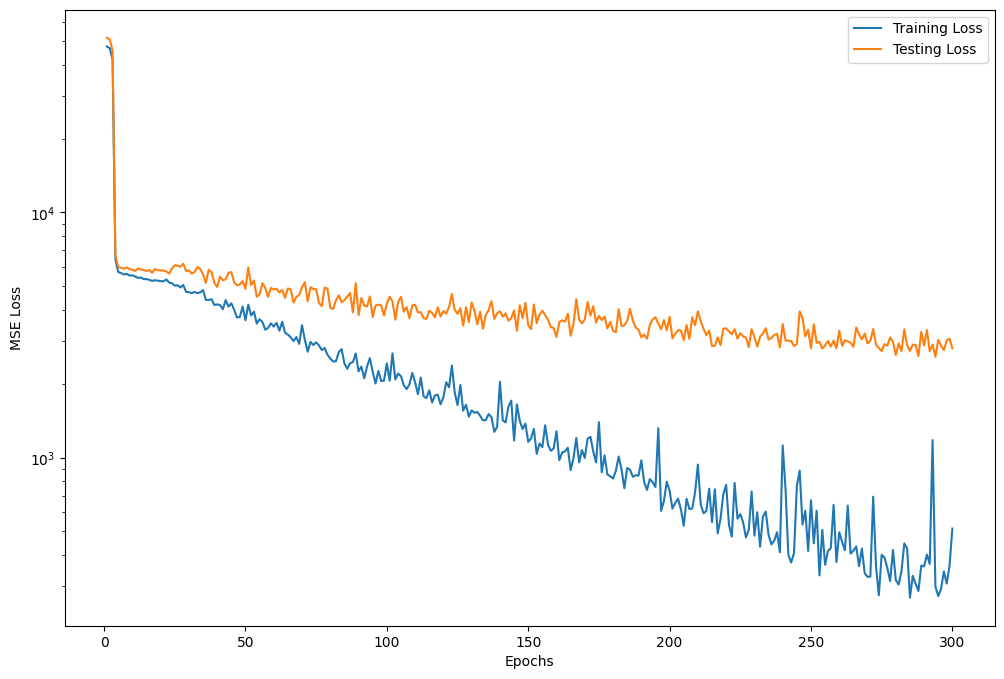

In [54]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(np.arange(1, n_epochs+1), losses_train, label='Training Loss')
ax.plot(np.arange(1, n_epochs+1), losses_test, label='Testing Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.set(yscale = "log")
ax.legend()

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

In [55]:
mlp_momentum = MLP(seed=1)
mlp_momentum.add_layer(12, 50)
mlp_momentum.add_layer(50, 50, "activation")
mlp_momentum.add_layer(50, 50, "activation")
mlp_momentum.add_layer(50, 1, "activation")

n_epochs = 300
mlp_momentum, losses_train_momentum, losses_test_momentum = sgd(X_train_std, y_train.to_numpy(), X_test_std, y_test.to_numpy(),
                                                                mlp_momentum, learning_rate = 5e-5,
                                                                n_epochs=n_epochs,
                                                                minibatchsize=8,
                                                                momentum=0.4)

  0%|          | 0/300 [00:00<?, ?it/s]

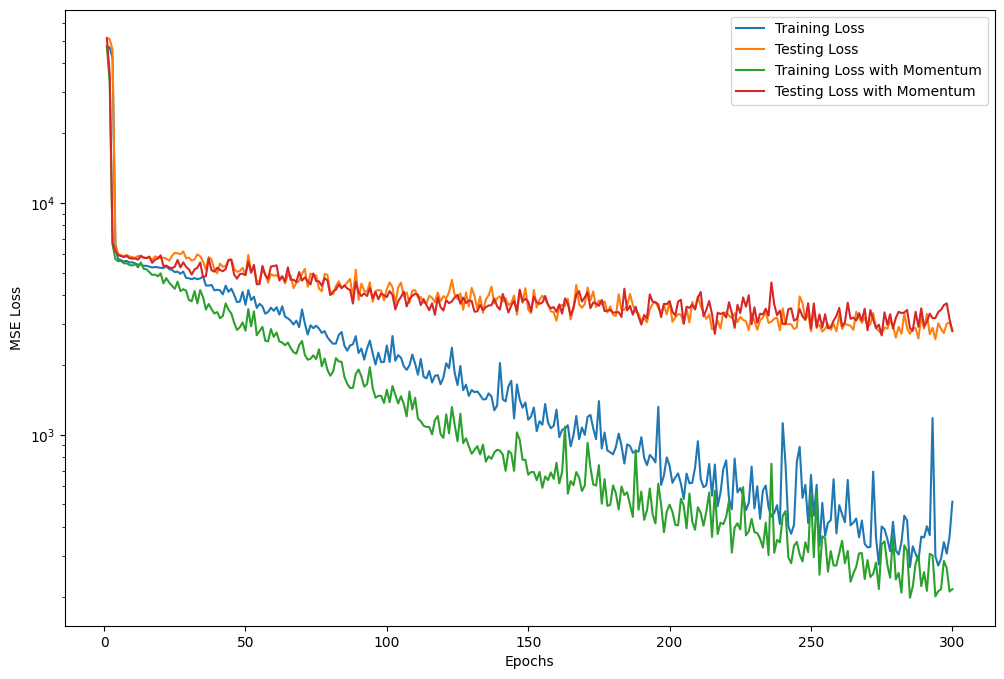

In [56]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(np.arange(1, n_epochs+1), losses_train, label='Training Loss')
ax.plot(np.arange(1, n_epochs+1), losses_test, label='Testing Loss')
ax.plot(np.arange(1, n_epochs+1), losses_train_momentum, label='Training Loss with Momentum')
ax.plot(np.arange(1, n_epochs+1), losses_test_momentum, label='Testing Loss with Momentum')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE Loss')
ax.set(yscale = "log")
ax.legend()

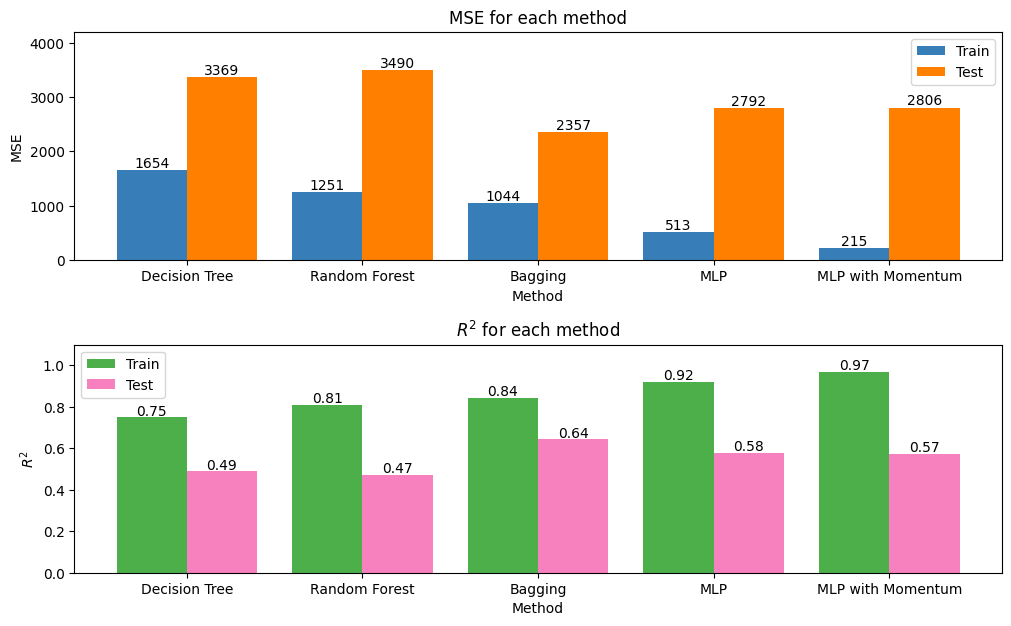

In [57]:
mlp_train_results = mlp_results(mlp, X_train_std, y_train.to_numpy())
mlp_test_results = mlp_results(mlp, X_test_std, y_test.to_numpy())
mlp_train_momentum_results = mlp_results(mlp_momentum, X_train_std, y_train.to_numpy())
mlp_test_momentum_results = mlp_results(mlp_momentum, X_test_std, y_test.to_numpy())

MSE_vals_train_2 = [tree_train_results[0], rf_train_results[0], bag_train_results[0], mlp_train_results[0], mlp_train_momentum_results[0]]
MSE_vals_test_2 = [tree_test_results[0], rf_test_results[0], bag_test_results[0], mlp_test_results[0], mlp_test_momentum_results[0]]
rsq_vals_train_2 = [tree_train_results[1], rf_train_results[1], bag_train_results[1], mlp_train_results[1], mlp_train_momentum_results[1]]
rsq_vals_test_2 = [tree_test_results[1], rf_test_results[1], bag_test_results[1], mlp_test_results[1], mlp_test_momentum_results[1]]

labels_2 = ['Decision Tree', 'Random Forest', 'Bagging', 'MLP', 'MLP with Momentum']

fig, ax = plt.subplots(2, 1, figsize = (10, 6))
fig.tight_layout(h_pad=4.0)

X_axis_2 = np.arange(len(labels_2))

ax[0].bar(X_axis_2 - 0.2, MSE_vals_train_2, 0.4, color = '#377eb8', label = 'Train')
ax[0].bar(X_axis_2 + 0.2, MSE_vals_test_2, 0.4, color = '#ff7f00', label = 'Test')
ax[0].set_ylabel('MSE')
ax[0].set_ylim(0, 4200)
ax[0].set_title('MSE for each method')
ax[0].legend(loc = 'upper right')
ax[0].set_xticks(X_axis_2, labels_2)
ax[0].set_xlabel('Method')

for i, v in enumerate(MSE_vals_train_2):
    ax[0].text(i - 0.2, v + 50, str(int(v)), ha = 'center')

for i, v in enumerate(MSE_vals_test_2):
    ax[0].text(i + 0.2, v + 50, str(int(v)), ha = 'center')

ax[1].bar(X_axis_2 - 0.2, rsq_vals_train_2, 0.4, color = '#4daf4a', label = 'Train')
ax[1].bar(X_axis_2 + 0.2, rsq_vals_test_2, 0.4, color = '#f781bf', label = 'Test')
ax[1].set_ylabel(r'$R^2$')
ax[1].set_ylim(0, 1.1)
ax[1].set_title(r'$R^2$ for each method')
ax[1].legend(loc = 'upper left')
ax[1].set_xticks(X_axis_2, labels_2)
ax[1].set_xlabel('Method')

for i, v in enumerate(rsq_vals_train_2):
    ax[1].text(i - 0.2, v + 0.01, str(round(v, 2)), ha = 'center')

for i, v in enumerate(rsq_vals_test_2):
    ax[1].text(i + 0.2, v + 0.01, str(round(v, 2)), ha = 'center')

<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)

In [58]:
def include_quadratic(X):
    """
    Include quadratic features in the input features array.

    Parameters:
        X (np.ndarray): The input features array, with shape (|D|, D).

    Returns:
        (np.ndarray): The input features array with quadratic features.
    """
    X_quadratic = X.to_numpy().copy()

    n, p = np.shape(X_quadratic)

    for i in range(0, p):
        for j in range(i, p):
            quad_term = X.to_numpy()[:, i] * X.to_numpy()[:, j]
            X_quadratic = np.c_[X_quadratic, quad_term]

    return X_quadratic

In [59]:
X_train_quadratic = include_quadratic(X_train)
X_test_quadratic = include_quadratic(X_test)

In [60]:
def ridge_estimate(X, y, penalty):

    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    N_aug, D_aug = X_aug.shape
    I = np.identity(D_aug)
    I[0, 0] = 0
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y) 
    return beta_ridge

In [61]:
def predict_ridge(X, beta):
    """
    Predict the target values using the ridge regression model.

    Parameters:
        X (np.ndarray): The input features array, with shape (|D|, D).
        beta_ridge (np.ndarray): The ridge regression coefficients, with shape (D, 1).

    Returns:
        (np.ndarray): The predicted target values.
    """
    X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_aug @ beta

In [62]:
def regression_ridge_plot(X, y, penalties):
    betas = []

    for penalty in penalties:
        betas.append(ridge_estimate(X, y, penalty))

    fig, ax = plt.subplots(len(penalties), 1, figsize = (12, 5*len(penalties)))
    colors = ['#377eb8', '#ff7f00', '#4daf4a']

    for i, penalty in enumerate(penalties):
        ax[i].plot(range(len(betas[0])), betas[i], color = colors[i])
        ax[i].set_xlabel(r'$i$')
        ax[i].set_ylabel(r'$\beta_i$')
        ax[i].set_title(f'Ridge Regression with $\lambda$ = {penalty}')
        ax[i].legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


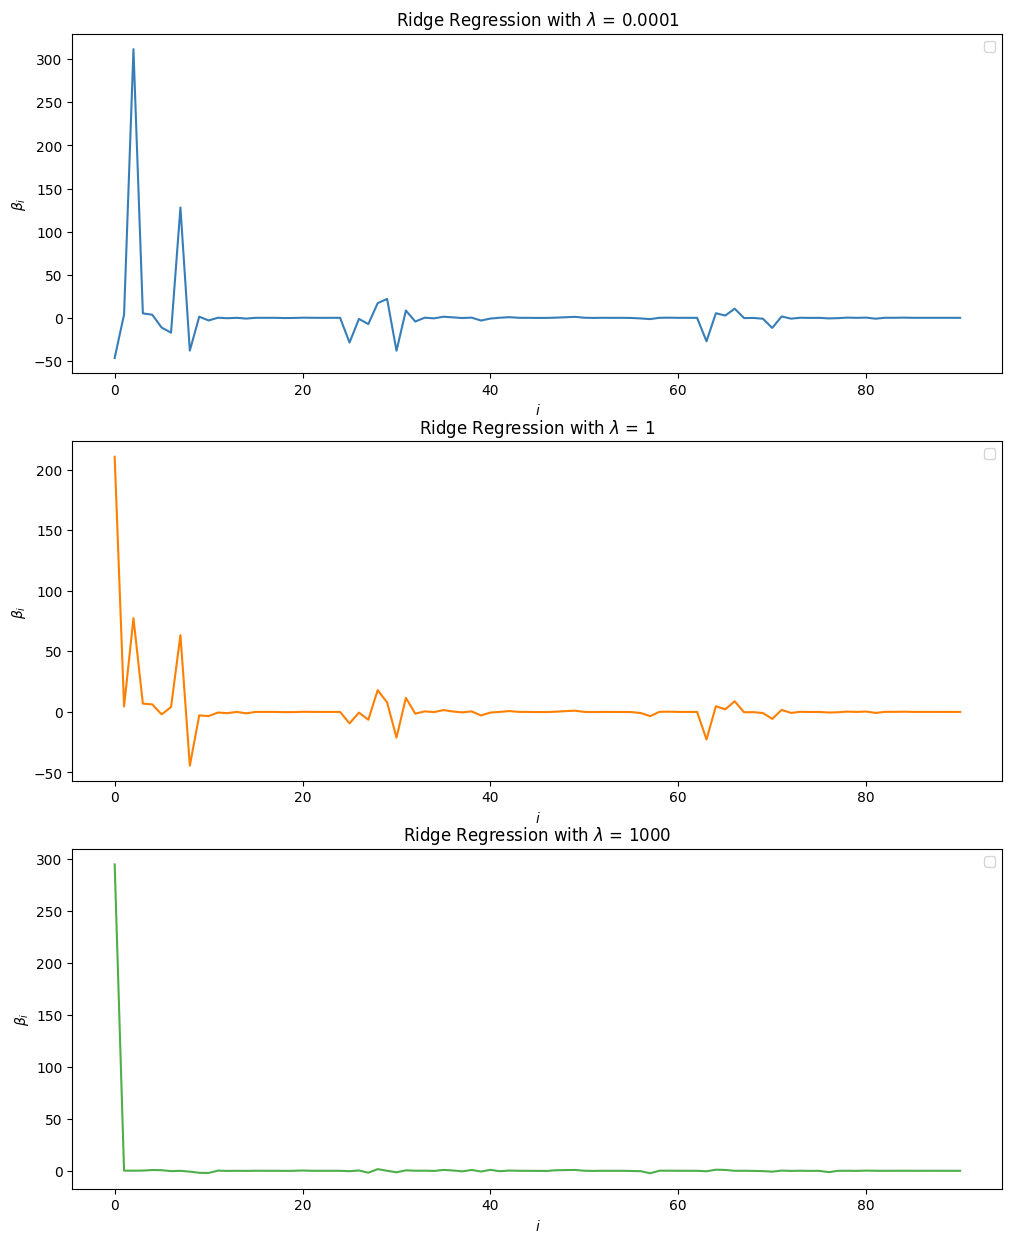

In [63]:
penalties = [0.0001, 1, 1000]

regression_ridge_plot(X_train_quadratic, y_train, penalties)

In [64]:
def ridge_cross_validation(X, y, penalty, n_folds=5):

  N = X.shape[0]
  fold_indices = np.array_split(np.arange(N), n_folds)
  scores = []

  for test_indices in fold_indices:
    train_indices = list(set(range(N)) - set(test_indices))
    X_train, X_test = X[train_indices, :], X[test_indices, :]
    y_train, y_test = y[train_indices], y[test_indices]

    beta = ridge_estimate(X_train, y_train, penalty)

    scores.append(mse(predict_ridge(X_test, beta), y_test.to_numpy()))

  # Return the average score
  return np.mean(scores) 

In [65]:
def choose_best_penalty(X_train, y_train, n_folds, max_penalty, n_points=1000):
  pen_range = np.geomspace(0.0001, max_penalty, n_points)
  best_mse = np.inf
  mses = []
  optimal_penalty = 0

  penalty_bar = tqdm(pen_range)
  
  for penalty in penalty_bar:
    mse = ridge_cross_validation(X_train, y_train, penalty, n_folds)
    mses.append(mse)
    penalty_bar.set_description(f'Penalty: {penalty:.2f}, MSE: {mse:.2f}')

    if mse < best_mse:
      best_mse = mse
      optimal_penalty = penalty
    
  fig, ax = plt.subplots(figsize = (12, 8))
  ax.plot(pen_range, mses, label='MSE')
  ax.set_xlabel(r'$\lambda$')
  ax.set_ylabel(r'$\langle MSE \rangle$')
  ax.set_title(r'MSE for each $\lambda$')

  return optimal_penalty

  0%|          | 0/1000 [00:00<?, ?it/s]

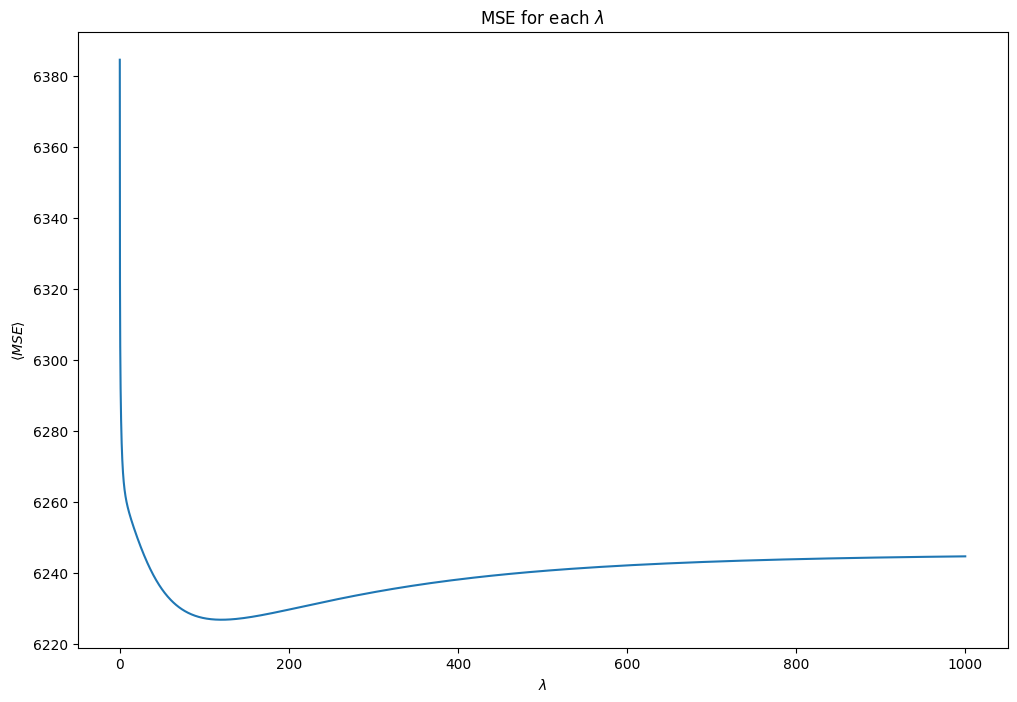

In [66]:
optimal_penalty_quad = choose_best_penalty(X_train_quadratic, y_train, 5, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

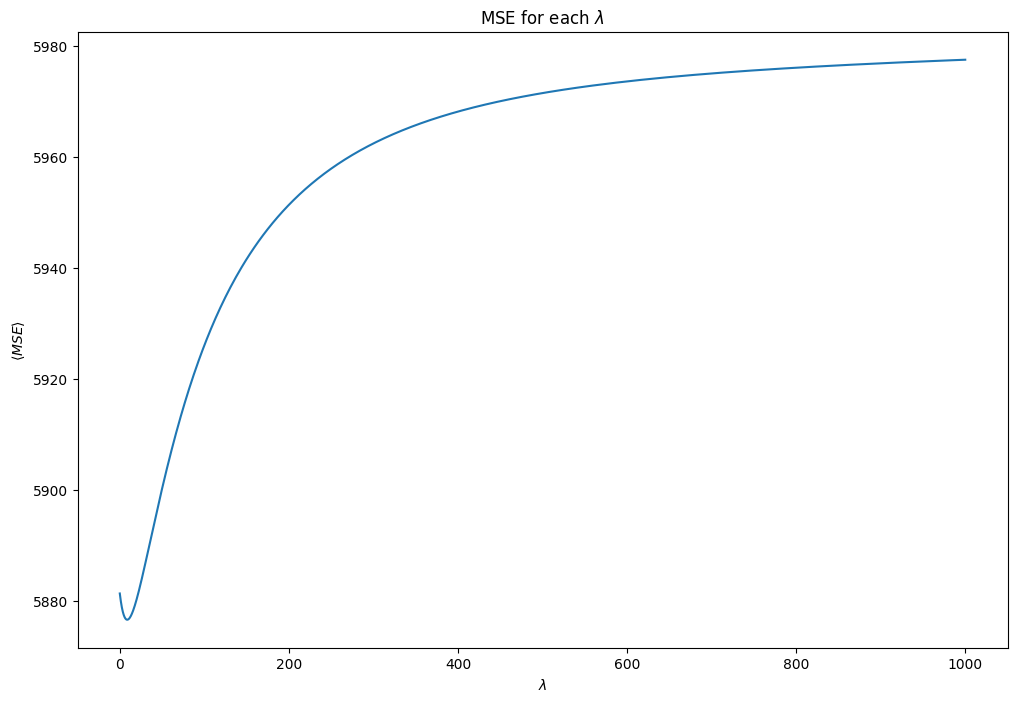

In [67]:
optimal_penalty_linear = choose_best_penalty(X_train.to_numpy(), y_train, 5, 1000)

In [74]:
mse(y_train.to_numpy(), predict_ridge(X_train_quadratic, ridge_estimate(X_train_quadratic, y_train, optimal_penalty_quad)))

array([3970.24677843])

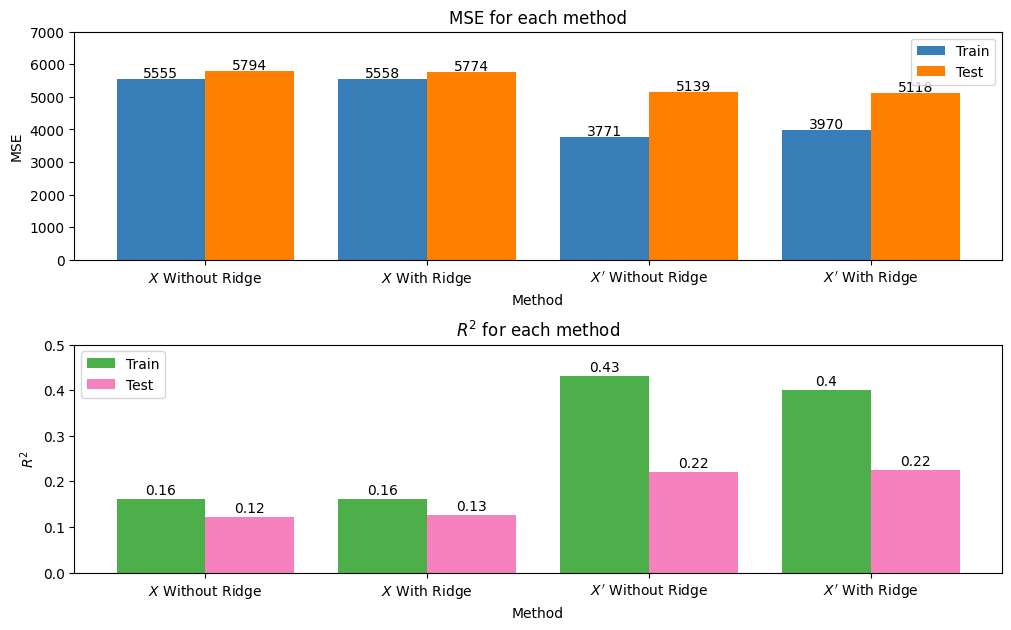

In [80]:
betas = [ridge_estimate(X_train.to_numpy(), y_train, 0), ridge_estimate(X_train.to_numpy(), y_train, optimal_penalty_linear), 
         ridge_estimate(X_train_quadratic, y_train, 0), ridge_estimate(X_train_quadratic, y_train, optimal_penalty_quad)]

y_hat_train = [predict_ridge(X_train.to_numpy(), betas[0]), predict_ridge(X_train.to_numpy(), betas[1]), 
               predict_ridge(X_train_quadratic, betas[2]), predict_ridge(X_train_quadratic, betas[3])]
y_hat_test = [predict_ridge(X_test.to_numpy(), betas[0]), predict_ridge(X_test.to_numpy(), betas[1]), 
              predict_ridge(X_test_quadratic, betas[2]), predict_ridge(X_test_quadratic, betas[3])]

MSE_vals_train_3 = [mse(y_train.to_numpy(), y_pred) for y_pred in y_hat_train]
MSE_vals_test_3 = [mse(y_test.to_numpy(), y_pred) for y_pred in y_hat_test]

rsq_vals_train_3 = [rsq(y_train.to_numpy(), y_pred) for y_pred in y_hat_train]
rsq_vals_test_3 = [rsq(y_test.to_numpy(), y_pred) for y_pred in y_hat_test]

labels_3 = ['$X$ Without Ridge', '$X$ With Ridge', '$X\'$ Without Ridge', '$X\'$ With Ridge']

fig, ax = plt.subplots(2, 1, figsize = (10, 6))
fig.tight_layout(h_pad=4.0)

X_axis_3 = np.arange(len(labels_3))

ax[0].bar(X_axis_3 - 0.2, MSE_vals_train_3, 0.4, color = '#377eb8', label = 'Train')
ax[0].bar(X_axis_3 + 0.2, MSE_vals_test_3, 0.4, color = '#ff7f00', label = 'Test')
ax[0].set_ylabel('MSE')
ax[0].set_ylim(0, 7000)
ax[0].set_title('MSE for each method')
ax[0].legend(loc = 'upper right')
ax[0].set_xticks(X_axis_3, labels_3)
ax[0].set_xlabel('Method')

for i, v in enumerate(MSE_vals_train_3):
    ax[0].text(i - 0.2, v + 50, str(int(v)), ha = 'center')

for i, v in enumerate(MSE_vals_test_3):
    ax[0].text(i + 0.2, v + 50, str(int(v)), ha = 'center')

ax[1].bar(X_axis_3 - 0.2, rsq_vals_train_3, 0.4, color = '#4daf4a', label = 'Train')
ax[1].bar(X_axis_3 + 0.2, rsq_vals_test_3, 0.4, color = '#f781bf', label = 'Test')
ax[1].set_ylabel(r'$R^2$')
ax[1].set_ylim(0, 0.5)
ax[1].set_title(r'$R^2$ for each method')
ax[1].legend(loc = 'upper left')
ax[1].set_xticks(X_axis_3, labels_3)
ax[1].set_xlabel('Method')

for i, v in enumerate(rsq_vals_train_3):
    ax[1].text(i - 0.2, v + 0.01, str(round(v, 2)), ha = 'center')

for i, v in enumerate(rsq_vals_test_3):
    ax[1].text(i + 0.2, v + 0.01, str(round(v, 2)), ha = 'center')



---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

In [81]:
data = pd.read_csv('brain_cancer_samples.csv')

X_train = data.drop("Class", axis = 'columns')
y_train = data["Class"]

test_data = pd.read_csv('brain_cancer_test.csv')
X_test = test_data.drop("Class", axis = 'columns')
y_test = test_data["Class"]

In [139]:
X_train.set_index('Patient ID', inplace = True)
X_test.set_index('Patient ID', inplace = True)

X_train = X_train[[column for column in X_train.columns if column != 'Location'] + ['Location']]
X_test = X_test[[column for column in X_test.columns if column != 'Location'] + ['Location']]

columns_dict = {index: False for index in range(X_train.shape[1])}
columns_dict[7] = True

X_train.head()

,2D Surface,Contour Size,Total Surface,Density,Diameter,Primary Axis,Shape Variation,Eccentricity_Real,Eccentricity_Imag,Location
Patient ID,,,,,,,,,,
1,1325.5,160.124890,1518.5,0.872901,41.081371,36.290924,53.992371,6.750000e-17,1.101565,2
2,81.5,39.556349,88.0,0.926136,10.186708,8.801125,15.591203,8.950000e-17,1.462264,2
3,57177.0,912.607209,57611.0,0.992467,269.814784,234.644165,312.589264,5.390000e-17,0.880179,4
4,135.0,92.083260,206.0,0.655340,13.110581,6.568726,40.183521,3.700000e-16,6.035112,3
5,6653.0,1525.307779,84025.5,0.079178,92.037290,383.980133,402.407623,1.920000e-17,0.313504,3


In [140]:
X_train_std = standardise(X_train.to_numpy())
X_test_std = standardise(X_test.to_numpy(), X_train_=X_train.to_numpy())

X_train_std[:, -1] = X_train['Location']
X_test_std[:, -1] = X_test['Location']

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

In [145]:
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p - q) ** 2))

In [146]:
def hamming_distance(p, q):
    return np.sum(p != q)

In [147]:
def distance(p, q, columns_categorical):
    return euclidian_distance(p[~columns_categorical], q[~columns_categorical]) + hamming_distance(p[columns_categorical], q[columns_categorical])

In [154]:
def k_neighbours(X_train, X_test, k=5, return_distance = False):
  neigh_ind = []
  dist = []

  
  # compute distance from each point x_text in X_test to all points in X_train (hint: use python's list comprehension: [... for x_test in X_test])
  point_dist = [euclidian_distance(x_test[0:-1], X_train[:, 0:-1]) + hamming_distance(x_test[-1], X_train[:, -1]) for x_test in X_test] 

  point_dist = [[euclidian_distance(x_test, x_train) for x_train in X_train] for x_test in X_test] ## not susre about this distance function
  # determine which k training points are closest to each test point
  for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]
      
      dist.append(dist_list)
      neigh_ind.append(ind_list)

  if return_distance:
    return np.array(dist), np.array(neigh_ind)

  return np.array(neigh_ind)

In [142]:
def knn_predict(X_train, y_train, X_test, k=5):
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_train, X_test, k=k)
  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax (hint: use python's list comprehension: np.array([... for neighbour in neighbours]))
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

  return y_pred

In [143]:
def knn_score(X_train, y_train, X_test, y_test, k=5):
  y_pred = knn_predict(X_train, y_train, X_test, k)
  return float(sum(y_pred == y_test)) / float(len(y_test))

In [153]:
knn_score(X_train_std, y_train, X_train_std, y_train, k=8)

0.8068965517241379

In [160]:
def knn_cross_validation_score(X_train, y_train, k):
  scores = []
  folds_indices = np.array_split(np.arange(len(y_train)), 5)
  for test_indices in folds_indices:
    train_indexes = list(set(range(y_train.shape[0])) - set(test_indices))
    
    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]


    X_val_i = X_train[test_indices, :] 
    y_val_i = y_train[test_indices] 

    scores.append(knn_score(X_train_i, y_train_i, X_val_i, y_val_i, k))

  # Return the average score
  return np.mean(scores) 

In [161]:
def choose_best_k(X_train, y_train, k_range):
  k_scores = np.zeros((len(k_range),))
  optimal_score = 0
  optimal_k = 0
  k_bar = tqdm(k_range)

  for i, k in enumerate(k_bar):
    score = knn_cross_validation_score(X_train, y_train, k)

    if score > optimal_score:
      optimal_score = score
      optimal_k = k

    k_scores[i] = knn_cross_validation_score(X_train, y_train, k)

  return optimal_k, k_scores

In [167]:
k_range = np.arange(1, 101)
best_k, k_scores = choose_best_k(X_train_std, y_train.to_numpy(), k_range)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, '$\\langle$ Score $\\rangle$ for each $k$')

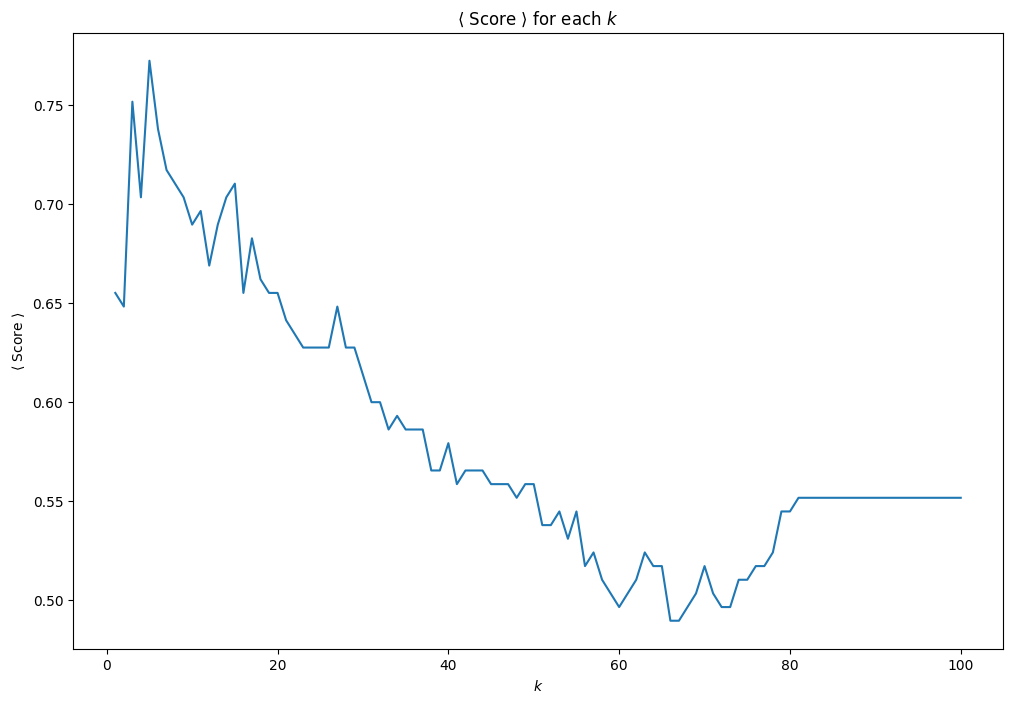

In [168]:
fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(k_range, k_scores)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\langle$ Score $\rangle$')
ax.set_title(r'$\langle$ Score $\rangle$ for each $k$')

In [173]:
print(f"Training score with k = {best_k} : {knn_score(X_train_std, y_train, X_train_std, y_train, best_k):.2f}")
print(f"Testing score with k = {best_k} : {knn_score(X_train_std, y_train, X_test_std, y_test, best_k):.2f}")

Training score with k = 5 : 0.81
Testing score with k = 5 : 0.72


In [174]:
np.bincount(y_train)

array([47, 80, 18])

In [175]:
##find averages and make inferences

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

In [206]:
def knn_predict_weighted(X_train, y_train, X_test, k=5, weights=None):

  y_pred = []

  if weights is None:
    weights = {value: 1 for weights in np.unique(y_train)}

  neighbours = k_neighbours(X_train, X_test, k=k)

  for neighbour in neighbours:
    w = [weights[y] for y in y_train[neighbour]]

    y_pred.append(np.argmax(np.bincount(y_train[neighbour], weights=w)))

  return np.array(y_pred)

In [207]:
def knn_score_weighted(X_train, y_train, X_test, y_test, k=5, weights=None):
  y_pred = knn_predict_weighted(X_train, y_train, X_test, k, weights)
  return float(sum(y_pred == y_test)) / float(len(y_test))

In [210]:
weights = 1 / np.bincount(y_train)

print(knn_score_weighted(X_train_std, y_train, X_train_std, y_train, k=best_k, weights=weights))
print(knn_score_weighted(X_train_std, y_train, X_test_std, y_test, k=best_k, weights=weights))

0.7586206896551724
0.5666666666666667


In [211]:
## find accuracies and make inferences

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

<a name="task-214"></a>

### (2.1.4) [(index)](#index-task-214)



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)